In [ ]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRanker, Pool

In [5]:
POS_FEATURES_PATH = 'pos_features.parquet'
NEG_FEATURES_PATH = 'neg_features_5kk.parquet'

In [4]:
pos_features = pl.scan_parquet(POS_FEATURES_PATH)
pos_features = pos_features.with_columns(
    pl.lit(1).alias('target')
)

neg_features = pl.scan_parquet(NEG_FEATURES_PATH)
neg_features = neg_features.with_columns(
    pl.lit(0).alias('target')
)

need_to_drop_cols = [
    'user_item_added_to_cart_total',
    'user_item_days_since_first_purchase',
    'user_item_days_since_last_purchase',
    'user_item_top_subdomain',
    ]

pos_features = pos_features.drop(need_to_drop_cols)
neg_features = neg_features.drop(need_to_drop_cols)

columns_to_cast = [
    'user_item_lifetime',
    'user_brand_cnt_orders',
    'user_brand_days_since_first_order',
    'user_brand_days_since_last_order',
    'user_brand_lifetime',
    'user_category_orders',
    'user_category_first_order_day',
    'user_category_last_order_day',
    'user_category_days_since_first_order',
    'user_category_days_since_last_order',
    'user_category_lifetime'
]

pos_features = pos_features.with_columns([
    pl.col(col).cast(pl.Float64) 
    for col in columns_to_cast 
    if col in pos_features.columns
])


critical_features = [
    'user_brand_cnt_orders',
    'user_brand_avg_price',
    'user_brand_min_price',
    'user_brand_max_price',
    'user_brand_std_price',
    'user_brand_lifetime',
    'user_brand_total_share',
    'user_brand_rank',
    'user_category_orders',
    'user_category_avg_price',
    'user_category_min_price',
    'user_category_max_price',
    'user_category_first_order_day',
    'user_category_last_order_day',
    'user_category_lifetime',
    'user_category_orders_share'
]
data = pl.concat([pos_features, neg_features], how="vertical")
data = data.drop_nulls(subset=critical_features)


X = data.drop('target').collect()
y = data.select('target').collect().to_numpy().flatten()


# first_emb = X.select('item_embedding').to_numpy()[0, 0]
# emb_dim = len(first_emb)
# item_embeddings = np.stack(X.select('item_embedding').to_numpy().flatten())
# item_emb_df = pl.DataFrame(
#     item_embeddings,
#     schema=[f'item_emb_{i}' for i in range(emb_dim)]
# )
# print(f"  Создано {emb_dim} колонок для item_embedding")

# first_emb = X.select('brand_embedding').to_numpy()[0, 0]
# emb_dim = len(first_emb)
# brand_embeddings = np.stack(X.select('brand_embedding').to_numpy().flatten())
# brand_emb_df = pl.DataFrame(
#     brand_embeddings,
#     schema=[f'brand_emb_{i}' for i in range(emb_dim)]
# )
# print(f"  Создано {emb_dim} колонок для brand_embedding")

# X = pl.concat([X, item_emb_df], how="horizontal")
# X = pl.concat([X, brand_emb_df], how="horizontal")


columns_to_drop = ['brand_embedding', 'item_embedding']

# Проверяем наличие каждой колонки перед удалением
if 'item_brand_embedding' in X.columns:
    columns_to_drop.append('item_brand_embedding')
if 'user_item_added_to_cart_total' in X.columns:
    columns_to_drop.append('user_item_added_to_cart_total')
if 'user_item_days_since_first_purchase' in X.columns:
    columns_to_drop.append('user_item_days_since_first_purchase')
if 'user_item_days_since_last_purchase' in X.columns:
    columns_to_drop.append('user_item_days_since_last_purchase')
if 'user_item_top_subdomain' in X.columns:
    columns_to_drop.append('user_item_top_subdomain')

if columns_to_drop:
    print(f"Удаляем колонки: {columns_to_drop}")
    X = X.drop([col for col in columns_to_drop if col in X.columns])


categorical_columns = [
    'user_socdem_cluster',
    'user_region',
    'user_id',
    'item_id',
    'item_brand_id'
]

for col in categorical_columns:
    if col in X.columns:
        X = X.with_columns(
            pl.col(col).cast(pl.Utf8).alias(col)
        )

categorical_features = [
    col_name for col_name, dtype in X.schema.items() 
    if dtype == pl.Utf8  # pl.Utf8 - строковый тип
]
print(f"\nНайдено категориальных признаков: {len(categorical_features)}")
print(f"Список: {categorical_features}")

/var/folders/5t/b05_gxx17hnftz_n3c82pt4h0000gn/T/ipykernel_11000/4216806932.py:38: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  if col in pos_features.columns


Удаляем колонки: ['brand_embedding', 'item_embedding', 'item_brand_embedding']

Найдено категориальных признаков: 9
Список: ['user_id', 'item_id', 'item_brand_id', 'user_os', 'user_main_subdomain', 'user_socdem_cluster', 'user_region', 'item_category', 'item_subcategory']


In [11]:
X_pandas = X.to_pandas()

X_train, X_val, y_train, y_val = train_test_split(
    X_pandas, y, 
    test_size=0.1,
    random_state=42,
    stratify=y
)

In [12]:
import pandas as pd
pd.Series(y_train).value_counts(), pd.Series(y_train).value_counts(True), 

(0    4183280
 1     812289
 Name: count, dtype: int64,
 0    0.837398
 1    0.162602
 Name: proportion, dtype: float64)

In [13]:
user_ids_train = X_train['user_id'].values
user_ids_val = X_val['user_id'].values

unique_users = np.unique(np.concatenate([user_ids_train, user_ids_val]))
user_to_group = {user: idx for idx, user in enumerate(unique_users)}

group_id_train = np.array([user_to_group[user] for user in user_ids_train])
group_id_val = np.array([user_to_group[user] for user in user_ids_val])
    
train_sort_idx = np.argsort(group_id_train)
X_train = X_train.iloc[train_sort_idx].reset_index(drop=True)
y_train = y_train[train_sort_idx]
group_id_train = group_id_train[train_sort_idx]

val_sort_idx = np.argsort(group_id_val)
X_val = X_val.iloc[val_sort_idx].reset_index(drop=True)
y_val = y_val[val_sort_idx]
group_id_val = group_id_val[val_sort_idx]

In [14]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_features,
    group_id=group_id_train
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=categorical_features,
    group_id=group_id_val
)

In [15]:
model = CatBoostRanker(
    iterations=100,              # количество деревьев
    loss_function='YetiRank',     # функция потерь для ранжирования
    eval_metric='NDCG',           # метрика для валидации (Normalized DCG)
    random_seed=42,               # для воспроизводимости
    verbose=10,                  # выводить информацию каждые 100 итераций
    early_stopping_rounds=50,     # остановка, если метрика не улучшается 50 итераций
    task_type='CPU',              # использовать CPU (можно 'GPU' если есть)
    thread_count=-1               # использовать все доступные ядра
)

# Обучаем модель
print("\nНачинаем обучение...")
model.fit(
    train_pool,
    eval_set=val_pool,            # валидационный набор для early stopping
    use_best_model=True,          # использовать модель с лучшей метрикой на валидации
    plot=True                    # не строить графики (для Jupyter можно True)
)


Начинаем обучение...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.8760967	best: 0.8760967 (0)	total: 7.29s	remaining: 12m 1s
10:	test: 0.8990193	best: 0.8990271 (9)	total: 1m 17s	remaining: 10m 23s
20:	test: 0.9046494	best: 0.9046494 (20)	total: 2m 26s	remaining: 9m 11s
30:	test: 0.9093150	best: 0.9093150 (30)	total: 3m 37s	remaining: 8m 4s
40:	test: 0.9111494	best: 0.9111494 (40)	total: 4m 51s	remaining: 6m 58s
50:	test: 0.9135207	best: 0.9135207 (50)	total: 6m 3s	remaining: 5m 49s
60:	test: 0.9143612	best: 0.9144064 (59)	total: 7m 14s	remaining: 4m 37s
70:	test: 0.9155096	best: 0.9155096 (70)	total: 8m 24s	remaining: 3m 25s
80:	test: 0.9156284	best: 0.9156480 (79)	total: 9m 35s	remaining: 2m 14s
90:	test: 0.9159659	best: 0.9159659 (90)	total: 10m 46s	remaining: 1m 3s
99:	test: 0.9161839	best: 0.9162431 (98)	total: 11m 51s	remaining: 0us

bestTest = 0.9162431279
bestIteration = 98

Shrink model to first 99 iterations.


In [16]:
model_path = 'catboost_ranker_model.cbm'
model.save_model(model_path)

In [ ]:
# model = CatBoostRanker()
# model_path = 'catboost_ranker_model.cbm'
# model.load_model(model_path)

In [17]:
X_all = pd.concat([X_train, X_val])
val_pred = model.predict(X_all)
X_all['score'] = val_pred

In [18]:
top_100 = X_all.groupby('user_id', group_keys=False).apply(
    lambda x: x.nlargest(100, 'score')
).reset_index(drop=True)

/var/folders/5t/b05_gxx17hnftz_n3c82pt4h0000gn/T/ipykernel_11000/3727234510.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_100 = X_all.groupby('user_id', group_keys=False).apply(


<Axes: >

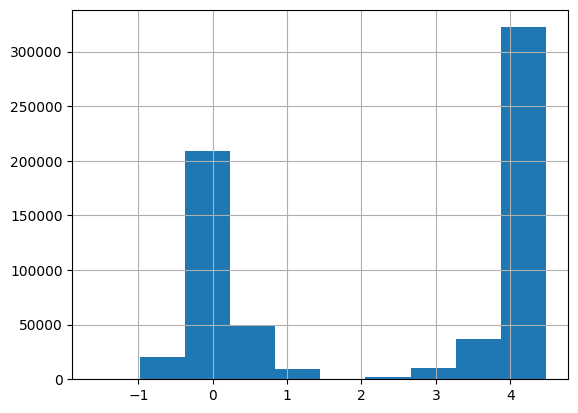

In [19]:
# X_val['score'].hist()
top_100['score'].hist()

In [20]:
top_100['user_id'] = top_100['user_id'].astype(np.int64)
top_100['item_id'] = top_100['item_id'].astype(np.int64)

top_100recs = top_100[['user_id', 'item_id']].groupby('user_id', as_index=False)['item_id'].apply(list)
top_100recs['user_id'] = top_100recs['user_id'].astype(np.int64)
top_100recs = top_100recs.sort_values('user_id').reset_index(drop=True)
top_100recs.columns = ['user_id', 'catboost_ranker_recs']
top_100recs.to_csv('top_100recs.csv', index=False)
top_100recs.head()

,user_id,catboost_ranker_recs
0,11,"[23317, 20331, 20331, 19213, 16561, 2101, 2104..."
1,14,"[21847, 21847, 16264, 17934, 11021, 27978, 180..."
2,21,"[26162, 26162, 17396, 24455, 24455, 24455, 244..."
3,29,"[8877, 1529, 15935, 15935, 24392, 29377, 29057..."
4,39,"[19586, 19586, 16405, 16572, 1321, 5472, 5472,..."


In [21]:
from tecd_retail_recsys.data import DataPreprocessor
dp = DataPreprocessor(day_begin=1082, day_end=1308, val_days=20, test_days=20, min_user_interactions=1, min_item_interactions=20)
train_df, val_df, test_df = dp.preprocess()
joined = dp.get_grouped_data(train_df, val_df, test_df)
joined['train_val_interactions'] = joined['train_interactions'] + joined['val_interactions']
print(joined.shape)

joined = joined.merge(top_100recs, on='user_id')

Starting data preprocessing...
Loading events from t_ecd_small_partial/dataset/small/retail/events
Loaded 236,479,226 total events
Loading items data from t_ecd_small_partial/dataset/small/retail/items.pq
Loaded 250,171 items with features: ['item_id', 'item_brand_id', 'item_category', 'item_subcategory', 'item_price', 'item_embedding']
Merged item features. Data shape: (236479226, 12)
Filtered to 3,758,762 events with action_type='added-to-cart'
After filtering (min_user_interactions=1, min_item_interactions=20): 3,249,972 events, 84,944 users, 30,954 items
Created mappings: 84944 users, 30954 items
Temporal split - Train: days < 1269 (902,543 events), Val: days 1269-1288 (228,339 events), Test: days >= 1289 (223,395 events)
Users in each part (train, val, test) - 7425
(7425, 5)


In [22]:
def remove_duplicate_items_fast(recommendations):
    """Быстрое удаление дубликатов с сохранением порядка"""
    if not recommendations:
        return []
    
    # dict сохраняет порядок вставки в Python 3.7+
    if isinstance(recommendations[0], tuple):
        # Формат [(item_id, score), ...]
        return list(dict.fromkeys(recommendations).keys())
    else:
        # Формат [item_id, ...]
        return list(dict.fromkeys(recommendations).keys())

joined['catboost_ranker_recs'] = joined['catboost_ranker_recs'].apply(remove_duplicate_items_fast)

In [23]:
print('Метрики на валидацинной выборке:')
from tecd_retail_recsys.metrics import calculate_metrics
val_metrics_catboost = calculate_metrics(joined, train_col='train_interactions', model_preds='catboost_ranker_recs', gt_col='val_interactions', verbose=True)

Метрики на валидацинной выборке:

At k=10:
  MAP@10       = 0.1079
  NDCG@10      = 0.2755
  Precision@10 = 0.1484
  Recall@10    = 0.0525

At k=100:
  MAP@100       = 0.0593
  NDCG@100      = 0.2139
  Precision@100 = 0.0559
  Recall@100    = 0.1727

Other Metrics:
  MRR                 = 0.2297
  Catalog Coverage    = 0.9584
  Diversity     = 0.9978  [0=same recs for all, 1=unique recs]
  Novelty             = 0.9035
  Serendipity         = 0.0421


In [26]:
feature_importances = model.get_feature_importance(type='PredictionValuesChange')
feature_names = X_train.columns
importance_df = sorted(
    zip(feature_names, feature_importances),
    key=lambda x: x[1],
    reverse=True
)
pd.DataFrame(importance_df, columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
0,user_item_viewed_total,54.115816
1,user_item_clicked_total,12.483717
2,user_item_lifetime,9.987548
3,user_brand_total_share,5.288943
4,item_uniq_users_total,4.433111
5,item_added_to_cart_total,3.300125
6,item_category,2.647179
7,user_category_orders,1.262384
8,item_added_to_cart_30d,1.069904
9,user_brand_cnt_orders,1.064922


# Инференс по всем парам (продакшн-вариант)

In [27]:
# # 1. Берем юзеров
# users = val_df['user_id'].unique()

# # 2. Для каждого юзера создаем пары со ВСЕМИ товарами
# all_items = items_df['item_id'].unique()

# inference_pairs = []
# for user_id in users:
#     for item_id in all_items:
#         inference_pairs.append({
#             'user_id': user_id,
#             'item_id': item_id,
#             'day': 1288  # Текущий день
#         })

# inference_df = pd.DataFrame(inference_pairs)

# # 3. Создаем фичи для ВСЕХ пар
# inference_features = add_features_to_samples(
#     inference_df,
#     train_df=train_df,
#     dp=dp,
#     end_day=1268
# )

# # 4. Предикт для ВСЕХ пар
# inference_features['score'] = ranker.predict_proba(inference_features[feature_cols])[:, 1]

# # 5. Топ-100 для каждого юзера
# recommendations = inference_features.groupby('user_id').apply(
#     lambda x: x.nlargest(100, 'score')
# ).reset_index(drop=True)

# # 6. Оценка
# val_ground_truth = val_df[['user_id', 'item_id']]
# hits = val_ground_truth.merge(recommendations, on=['user_id', 'item_id'])

# recall_at_100 = len(hits) / len(val_ground_truth)

### Добавляю кандидато-генераторов

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from tecd_retail_recsys.data import DataPreprocessor
from tecd_retail_recsys.models import TopPopular, TopPersonal, EASE, iALS, TIFUKNN

In [4]:
dp = DataPreprocessor(day_begin=1082, day_end=1308, val_days=20, test_days=20, min_user_interactions=1, min_item_interactions=20)
train_df, val_df, test_df = dp.preprocess()
joined = dp.get_grouped_data(train_df, val_df, test_df)
joined['train_val_interactions'] = joined['train_interactions'] + joined['val_interactions']
print(joined.shape)

Starting data preprocessing...
Loading events from t_ecd_small_partial/dataset/small/retail/events
Loaded 236,479,226 total events
Loading items data from t_ecd_small_partial/dataset/small/retail/items.pq
Loaded 250,171 items with features: ['item_id', 'item_brand_id', 'item_category', 'item_subcategory', 'item_price', 'item_embedding']
Merged item features. Data shape: (236479226, 12)
Filtered to 3,758,762 events with action_type='added-to-cart'
After filtering (min_user_interactions=1, min_item_interactions=20): 3,249,972 events, 84,944 users, 30,954 items
Created mappings: 84944 users, 30954 items
Temporal split - Train: days < 1269 (902,543 events), Val: days 1269-1288 (228,339 events), Test: days >= 1289 (223,395 events)
Users in each part (train, val, test) - 7425
(7425, 5)


In [5]:
### TopPopular

In [6]:
toppop_val = TopPopular()
toppop_val.fit(joined, col='train_interactions')
joined['toppopular_recs_val'] = toppop_val.predict(joined, topn=1000, return_scores=True)

In [ ]:
result = joined[['user_id', 'toppopular_recs_val']].explode('toppopular_recs_val')
result[['item_id', 'score']] = result['toppopular_recs_val'].apply(pd.Series)
result = result.drop('toppopular_recs_val', axis=1)
result['item_id'] = result['item_id'].astype(np.int64)
result.to_parquet('toppopular_val_recs.parquet', index=False)

In [ ]:
### TopPersonal

In [27]:
toppers_val = TopPersonal()
toppers_val.fit(joined, col='train_interactions')
joined['toppersonal_recs_val'] = toppers_val.predict(joined, topn=1000, return_scores=True)

In [29]:
result = joined[['user_id', 'toppersonal_recs_val']].explode('toppersonal_recs_val')
result[['item_id', 'score']] = result['toppersonal_recs_val'].apply(pd.Series)
result = result.drop('toppersonal_recs_val', axis=1)
result['item_id'] = result['item_id'].astype(np.int64)
result.to_parquet('toppersonal_val_recs.parquet', index=False)

In [33]:
### EASE

In [34]:
# создадим матрицу интеракций
matrix_train, idx_to_item_train = dp.get_interactions_matrix(joined, col='train_interactions')
print(matrix_train.shape)

ease_val = EASE(idx_to_item=idx_to_item_train, reg_weight=1000)
ease_val.fit(matrix_train)
joined['ease_recs_val'] = ease_val.predict(joined, topn=1000, return_scores=True)

(7425, 30751)


In [36]:
result = joined[['user_id', 'ease_recs_val']].explode('ease_recs_val')
result[['item_id', 'score']] = result['ease_recs_val'].apply(pd.Series)
result = result.drop('ease_recs_val', axis=1)
result['item_id'] = result['item_id'].astype(np.int64)
result.to_parquet('ease_val_recs.parquet', index=False)

In [ ]:
### iALS

In [40]:
ials_train = iALS(idx_to_item=idx_to_item_train)
ials_train.fit(matrix_train)    
joined['ials_recs_val'] = ials_train.predict(joined, topn=1000, return_scores=True)

Iter № 1/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8497.26it/s]


Iter № 2/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8665.81it/s]


Iter № 3/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8532.51it/s]


Iter № 4/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8724.79it/s]


Iter № 5/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8494.84it/s]


Iter № 6/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8707.02it/s]


Iter № 7/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8810.75it/s]


Iter № 8/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8518.69it/s]


Iter № 9/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8834.31it/s]


Iter № 10/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8752.07it/s]


In [41]:
result = joined[['user_id', 'ials_recs_val']].explode('ials_recs_val')
result[['item_id', 'score']] = result['ials_recs_val'].apply(pd.Series)
result = result.drop('ials_recs_val', axis=1)
result['item_id'] = result['item_id'].astype(np.int64)
result.to_parquet('ials_val_recs.parquet', index=False)

In [ ]:
### tifu-knn

In [42]:
tifu_train = TIFUKNN(n_neighbors=1000)
tifu_train.fit(joined, col='train_interactions')
joined['tifuknn_recs_val'] = tifu_train.predict(joined, topn=1000, return_scores=True)

Building TIFU-KNN PIF vectors for 7425 users and 30751 items...


Computing PIF: 100%|██████████| 7425/7425 [00:00<00:00, 14222.09it/s]


Precomputing user similarities and neighbors...
Finding 1000 nearest neighbors for each user...


Finding neighbors: 100%|██████████| 7425/7425 [00:00<00:00, 11000.88it/s]


Precomputing collaborative signals...


Computing neighbor PIF: 100%|██████████| 7425/7425 [00:47<00:00, 156.40it/s]


TIFU-KNN training completed!
TIFU-KNN training completed!
Generating recommendations for 7425 users...
Masking interacted items...


Creating masks: 100%|██████████| 7425/7425 [00:00<00:00, 36368.16it/s]


Computing top-N recommendations...


Extracting top-N: 100%|██████████| 7425/7425 [00:03<00:00, 2180.63it/s]


In [43]:
result = joined[['user_id', 'tifuknn_recs_val']].explode('tifuknn_recs_val')
result[['item_id', 'score']] = result['tifuknn_recs_val'].apply(pd.Series)
result = result.drop('tifuknn_recs_val', axis=1)
result['item_id'] = result['item_id'].astype(np.int64)
result.to_parquet('tifuknn_val_recs.parquet', index=False)

# 2-уровневая архитектура

In [20]:
pos_features = pl.scan_parquet(POS_FEATURES_PATH)
pos_features = pos_features.with_columns(
    pl.lit(1).alias('target')
)

neg_features = pl.scan_parquet(NEG_FEATURES_PATH)
neg_features = neg_features.with_columns(
    pl.lit(0).alias('target')
)

need_to_drop_cols = [
    'user_item_added_to_cart_total',
    'user_item_days_since_first_purchase',
    'user_item_days_since_last_purchase',
    'user_item_top_subdomain',
    ]

pos_features = pos_features.drop(need_to_drop_cols)
neg_features = neg_features.drop(need_to_drop_cols)

columns_to_cast = [
    'user_item_lifetime',
    'user_brand_cnt_orders',
    'user_brand_days_since_first_order',
    'user_brand_days_since_last_order',
    'user_brand_lifetime',
    'user_category_orders',
    'user_category_first_order_day',
    'user_category_last_order_day',
    'user_category_days_since_first_order',
    'user_category_days_since_last_order',
    'user_category_lifetime'
]

pos_features = pos_features.with_columns([
    pl.col(col).cast(pl.Float64) 
    for col in columns_to_cast 
    if col in pos_features.columns
])


critical_features = [
    'user_brand_cnt_orders',
    'user_brand_avg_price',
    'user_brand_min_price',
    'user_brand_max_price',
    'user_brand_std_price',
    'user_brand_lifetime',
    'user_brand_total_share',
    'user_brand_rank',
    'user_category_orders',
    'user_category_avg_price',
    'user_category_min_price',
    'user_category_max_price',
    'user_category_first_order_day',
    'user_category_last_order_day',
    'user_category_lifetime',
    'user_category_orders_share'
]
data = pl.concat([pos_features, neg_features], how="vertical")
data = data.drop_nulls(subset=critical_features)


X = data.drop('target').collect()
y = data.select('target').collect().to_numpy().flatten()

columns_to_drop = ['brand_embedding', 'item_embedding']

if 'item_brand_embedding' in X.columns:
    columns_to_drop.append('item_brand_embedding')
if 'user_item_added_to_cart_total' in X.columns:
    columns_to_drop.append('user_item_added_to_cart_total')
if 'user_item_days_since_first_purchase' in X.columns:
    columns_to_drop.append('user_item_days_since_first_purchase')
if 'user_item_days_since_last_purchase' in X.columns:
    columns_to_drop.append('user_item_days_since_last_purchase')
if 'user_item_top_subdomain' in X.columns:
    columns_to_drop.append('user_item_top_subdomain')

if columns_to_drop:
    print(f"Удаляем колонки: {columns_to_drop}")
    X = X.drop([col for col in columns_to_drop if col in X.columns])


categorical_columns = [
    'user_socdem_cluster',
    'user_region',
    'user_id',
    'item_id',
    'item_brand_id'
]

for col in categorical_columns:
    if col in X.columns:
        X = X.with_columns(
            pl.col(col).cast(pl.Utf8).alias(col)
        )

categorical_features = [
    col_name for col_name, dtype in X.schema.items() 
    if dtype == pl.Utf8  # pl.Utf8 - строковый тип
]
print(f"\nНайдено категориальных признаков: {len(categorical_features)}")
print(f"Список: {categorical_features}")


# ===========================================

print('base data ready!')
X = X.lazy().with_columns([
    pl.col('user_id').cast(pl.Int64),
    pl.col('item_id').cast(pl.Int64)
])

toppop_scores = pl.scan_parquet('toppopular_val_recs.parquet').rename({'score': 'toppop_score'})
X = X.join(toppop_scores, on=['user_id', 'item_id'], how='left').with_columns(
    pl.col("toppop_score").fill_null(0)
)

toppers_scores = pl.scan_parquet('toppersonal_val_recs.parquet').rename({'score': 'toppers_score'})
X = X.join(toppers_scores, on=['user_id', 'item_id'], how='left').with_columns(
    pl.col("toppers_score").fill_null(0)
)

ease_scores = pl.scan_parquet('ease_val_recs.parquet').rename({'score': 'ease_score'})
X = X.join(ease_scores, on=['user_id', 'item_id'], how='left').with_columns(
    pl.col("ease_score").fill_null(0)
)

ials_scores = pl.scan_parquet('ials_val_recs.parquet').rename({'score': 'ials_score'})
X = X.join(ials_scores, on=['user_id', 'item_id'], how='left').with_columns(
    pl.col("ials_score").fill_null(0)
)

tifu_scores = pl.scan_parquet('tifuknn_val_recs.parquet').rename({'score': 'tifu_score'})
X = X.join(tifu_scores, on=['user_id', 'item_id'], how='left').with_columns(
    pl.col("tifu_score").fill_null(0)
)

y_lazy = pl.from_pandas(pd.DataFrame(y, columns=['target'])).lazy()
data = pl.concat([X, y_lazy], how='horizontal')
data.sink_parquet('features_with_scores.parquet')

/var/folders/5t/b05_gxx17hnftz_n3c82pt4h0000gn/T/ipykernel_19364/1897873590.py:38: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  if col in pos_features.columns


Удаляем колонки: ['brand_embedding', 'item_embedding', 'item_brand_embedding']

Найдено категориальных признаков: 9
Список: ['user_id', 'item_id', 'item_brand_id', 'user_os', 'user_main_subdomain', 'user_socdem_cluster', 'user_region', 'item_category', 'item_subcategory']
base data ready!


In [47]:
data = pd.read_parquet('features_with_scores.parquet')
X, y = data.drop('target', axis=1), data['target']
y = y.to_numpy()


users_train, users_val = train_test_split(
    unique_users,
    test_size=0.1,  # 10% пользователей в валидацию
    random_state=42
)

print(f"Пользователей в train: {len(users_train)}")
print(f"Пользователей в val: {len(users_val)}")

# 3. Фильтруем данные по пользователям
train_mask = X['user_id'].isin(users_train)
val_mask = X['user_id'].isin(users_val)

X_train = X[train_mask].reset_index(drop=True)
X_val = X[val_mask].reset_index(drop=True)

y_train = y[train_mask]
y_val = y[val_mask]

Пользователей в train: 6682
Пользователей в val: 743


In [48]:
print(f"Размер train: {len(X_train)} пар")
print(f"Размер val: {len(X_val)} пар")

Размер train: 5008280 пар
Размер val: 542353 пар


In [49]:


# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, 
#     test_size=0.1,
#     random_state=42,
#     stratify=y
# )
del data

user_ids_train = X_train['user_id'].values
user_ids_val = X_val['user_id'].values

unique_users = np.unique(np.concatenate([user_ids_train, user_ids_val]))
user_to_group = {user: idx for idx, user in enumerate(unique_users)}

group_id_train = np.array([user_to_group[user] for user in user_ids_train])
group_id_val = np.array([user_to_group[user] for user in user_ids_val])
    
train_sort_idx = np.argsort(group_id_train)
X_train = X_train.iloc[train_sort_idx].reset_index(drop=True)
y_train = y_train[train_sort_idx]
group_id_train = group_id_train[train_sort_idx]

val_sort_idx = np.argsort(group_id_val)
X_val = X_val.iloc[val_sort_idx].reset_index(drop=True)
y_val = y_val[val_sort_idx]
group_id_val = group_id_val[val_sort_idx]

In [50]:
categorical_features=['user_id', 'item_id', 'item_brand_id', 'user_os', 'user_main_subdomain', 'user_socdem_cluster', 'user_region', 'item_category', 'item_subcategory']

X_train.drop(columns=['tifu_score'], inplace=True)
X_val.drop(columns=['tifu_score'], inplace=True)

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_features,
    group_id=group_id_train
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=categorical_features,
    group_id=group_id_val
)

In [67]:
model = CatBoostRanker(
    iterations=100,              # количество деревьев
    loss_function='YetiRankPairwise:top=100',     # функция потерь для ранжирования
    eval_metric='NDCG:top=100',           # метрика для валидации (Normalized DCG)
    random_seed=42,               # для воспроизводимости
    verbose=10,                  # выводить информацию каждые 100 итераций
    early_stopping_rounds=50,     # остановка, если метрика не улучшается 50 итераций
    task_type='CPU',              # использовать CPU (можно 'GPU' если есть)
    thread_count=-1               # использовать все доступные ядра
)

# Обучаем модель
print("\nНачинаем обучение...")
model.fit(
    train_pool,
    eval_set=val_pool,            # валидационный набор для early stopping
    use_best_model=True,          # использовать модель с лучшей метрикой на валидации
    plot=True                    # не строить графики (для Jupyter можно True)
)


Начинаем обучение...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Pairwise scoring loss functions on CPU do not support one hot features. OneHotMaxSize set to 1
0:	test: 0.7559875	best: 0.7559875 (0)	total: 10.2s	remaining: 16m 45s
10:	test: 0.7830414	best: 0.7830414 (10)	total: 1m 56s	remaining: 15m 41s
20:	test: 0.7855739	best: 0.7855739 (20)	total: 3m 40s	remaining: 13m 49s
30:	test: 0.8003273	best: 0.8003273 (30)	total: 5m 25s	remaining: 12m 4s
40:	test: 0.8041895	best: 0.8041895 (40)	total: 7m 7s	remaining: 10m 15s
50:	test: 0.8048508	best: 0.8050200 (47)	total: 8m 49s	remaining: 8m 28s
60:	test: 0.8057883	best: 0.8057883 (60)	total: 10m 31s	remaining: 6m 43s
70:	test: 0.8093512	best: 0.8093512 (70)	total: 12m 13s	remaining: 4m 59s
80:	test: 0.8105140	best: 0.8105282 (79)	total: 13m 56s	remaining: 3m 16s
90:	test: 0.8105933	best: 0.8105933 (90)	total: 15m 40s	remaining: 1m 33s
99:	test: 0.8111223	best: 0.8111601 (95)	total: 17m 15s	remaining: 0us

bestTest = 0.8111600715
bestIteration = 95

Shrink model to first 96 iterations.


In [68]:
feature_importances = model.get_feature_importance(type='PredictionValuesChange')
feature_names = X_train.columns
importance_df = sorted(
    zip(feature_names, feature_importances),
    key=lambda x: x[1],
    reverse=True
)
pd.DataFrame(importance_df, columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
0,toppers_score,47.493238
1,item_uniq_users_30d,15.773995
2,user_brand_total_share,13.335429
3,item_uniq_users_7d,8.427605
4,item_added_to_cart_30d,5.003835
...,...,...
29,item_relative_category_price,0.000000
30,item_deviation_category_price,0.000000
32,item_clicked_total,0.000000
33,item_viewed_total,0.000000


In [76]:
model.save_model('catboost_ranker_with_scores_model.cbm')

In [70]:
X_pred = model.predict(X)
X['score'] = X_pred

top_100 = X.groupby('user_id', group_keys=False).apply(
    lambda x: x.nlargest(100, 'score')
).reset_index(drop=True)


top_100['user_id'] = top_100['user_id'].astype(np.int64)
top_100['item_id'] = top_100['item_id'].astype(np.int64)

top_100recs = top_100[['user_id', 'item_id']].groupby('user_id', as_index=False)['item_id'].apply(list)
top_100recs['user_id'] = top_100recs['user_id'].astype(np.int64)
top_100recs = top_100recs.sort_values('user_id').reset_index(drop=True)
top_100recs.columns = ['user_id', 'catboost_ranker_with_scores_recs']
top_100recs.to_csv('top_100recs_2.csv', index=False)
top_100recs.head()

,user_id,catboost_ranker_with_scores_recs
0,11,"[9323, 21151, 18383, 10104, 3094, 7801, 2145, ..."
1,14,"[7548, 10813, 17396, 2630, 3592, 16892, 7529, ..."
2,21,"[16892, 21895, 1809, 28042, 29051, 29189, 5633..."
3,29,"[15552, 29228, 29228, 7270, 5987, 21576, 1683,..."
4,39,"[17633, 8589, 16749, 25712, 29757, 28042, 2579..."


In [ ]:
from tecd_retail_recsys.data import DataPreprocessor
dp = DataPreprocessor(day_begin=1082, day_end=1308, val_days=20, test_days=20, min_user_interactions=1, min_item_interactions=20)
train_df, val_df, test_df = dp.preprocess()
joined = dp.get_grouped_data(train_df, val_df, test_df)
joined['train_val_interactions'] = joined['train_interactions'] + joined['val_interactions']

joined = joined.merge(top_100recs, on='user_id')

In [72]:
joined.head()

,user_id,train_interactions,val_interactions,test_interactions,train_val_interactions,catboost_ranker_with_scores_recs
0,11,"[(8476, 95399246, -5.233), (7952, 95411006, -3...","[(8591, 110164749, -4.965), (4010, 110185189, ...","[(18369, 112022725, -4.692), (29875, 112032227...","[(8476, 95399246, -5.233), (7952, 95411006, -3...","[9323, 21151, 18383, 10104, 3094, 7801, 2145, ..."
1,14,"[(11776, 98623953, -2.672), (11360, 98624852, ...","[(30789, 111213199, 0.0), (17585, 111242301, -...","[(8664, 111400827, -4.888), (10311, 111404767,...","[(11776, 98623953, -2.672), (11360, 98624852, ...","[7548, 10813, 17396, 2630, 3592, 16892, 7529, ..."
2,21,"[(16067, 105087839, -3.838), (6548, 105089789,...","[(2195, 109690171, -4.252), (24455, 109704924,...","[(5535, 111584788, -3.207), (25886, 111614896,...","[(16067, 105087839, -3.838), (6548, 105089789,...","[16892, 21895, 1809, 28042, 29051, 29189, 5633..."
3,29,"[(24855, 105300569, -3.779), (1228, 105347095,...","[(10268, 111157530, -4.484), (2169, 111175402,...","[(22555, 111565119, -4.273), (5342, 111585126,...","[(24855, 105300569, -3.779), (1228, 105347095,...","[15552, 29228, 29228, 7270, 5987, 21576, 1683,..."
4,39,"[(18478, 97610336, -3.804), (26949, 97898345, ...","[(30001, 110120451, -4.079), (19002, 110125294...","[(13391, 111576876, -4.481), (14124, 111591192...","[(18478, 97610336, -3.804), (26949, 97898345, ...","[17633, 8589, 16749, 25712, 29757, 28042, 2579..."


In [73]:
def remove_duplicate_items_fast(recommendations):
    """Быстрое удаление дубликатов с сохранением порядка"""
    if not recommendations:
        return []
    
    # dict сохраняет порядок вставки в Python 3.7+
    if isinstance(recommendations[0], tuple):
        # Формат [(item_id, score), ...]
        return list(dict.fromkeys(recommendations).keys())
    else:
        # Формат [item_id, ...]
        return list(dict.fromkeys(recommendations).keys())

joined['catboost_ranker_with_scores_recs'] = joined['catboost_ranker_with_scores_recs'].apply(remove_duplicate_items_fast)

In [74]:
print('Метрики на валидацинной выборке:')
from tecd_retail_recsys.metrics import calculate_metrics
val_metrics_catboost = calculate_metrics(joined, train_col='train_interactions', model_preds='catboost_ranker_with_scores_recs', gt_col='val_interactions', verbose=True)

Метрики на валидацинной выборке:

At k=10:
  MAP@10       = 0.0129
  NDCG@10      = 0.0415
  Precision@10 = 0.0278
  Recall@10    = 0.0095

At k=100:
  MAP@100       = 0.0057
  NDCG@100      = 0.0368
  Precision@100 = 0.0106
  Recall@100    = 0.0377

Other Metrics:
  MRR                 = 0.0831
  Catalog Coverage    = 0.8935
  Diversity     = 0.9974  [0=same recs for all, 1=unique recs]
  Novelty             = 0.8684
  Serendipity         = 0.0871


In [75]:
test_metrics_catboost = calculate_metrics(joined, train_col='train_interactions', model_preds='catboost_ranker_with_scores_recs', gt_col='test_interactions', verbose=True)


At k=10:
  MAP@10       = 0.0125
  NDCG@10      = 0.0396
  Precision@10 = 0.0250
  Recall@10    = 0.0086

At k=100:
  MAP@100       = 0.0056
  NDCG@100      = 0.0350
  Precision@100 = 0.0096
  Recall@100    = 0.0356

Other Metrics:
  MRR                 = 0.0770
  Catalog Coverage    = 0.8935
  Diversity     = 0.9974  [0=same recs for all, 1=unique recs]
  Novelty             = 0.8684
  Serendipity         = 0.0871
